# March Machine Learning Mania
In this notebook, we:
- Try different models/features and assess their performance.
- Simulate multiple 2024 March Madness brackets.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gc import collect
import os
import sys
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor, StackingClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import root_mean_squared_error, r2_score, log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor, XGBClassifier

from bayes_opt import BayesianOptimization

# display 100 rows and 100 columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

# global random seed
SEED = 0

# set numpy seed
np.random.seed(SEED)

## Load Data

In [22]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'

# load in features compact
features = pd.read_csv(root + 'processed/features_detailed_3.csv')

# team names
# teams = pd.concat([pd.read_csv(mroot + 'MTeams.csv'), pd.read_csv(wroot + 'WTeams.csv')], ignore_index=True)

# create a map for team names
# team_map = teams.set_index('TeamID')['TeamName']

## Rearranging the Data
When we input a new row into our model (for the 2024 bracket), the winner could be the first or the second team in the row that we input into our model. Currently, all rows have the winning team on the left, and this will cause our model to learn this locational information. We need to rearrange the order of winners and losers, to where it is essentially random to prevent the model from learning this.

In [24]:
# rename W, L to A, B
features.columns = [x.replace('W', 'A_', 1) if x[0] == 'W' else x for x in features.columns]
features.columns = [x.replace('L', 'B_', 1) if x[0] == 'L' else x for x in features.columns]

# check
features.head()

,Season,A_TeamID,A_Score,B_TeamID,B_Score,NumOT,A_PlayIn,B_PlayIn,A_SeedNum,B_SeedNum,A_num_games,A_win_ratio,A_avg_Score_for,A_avg_Score_against,A_std_Score_for,A_std_Score_against,A_avg_FGPct2_for,A_avg_FGPct2_against,A_std_FGPct2_for,A_std_FGPct2_against,A_avg_FGPct3_for,A_avg_FGPct3_against,A_std_FGPct3_for,A_std_FGPct3_against,A_avg_FTPct_for,A_avg_FTPct_against,A_std_FTPct_for,A_std_FTPct_against,A_avg_Ast_for,A_avg_Ast_against,A_std_Ast_for,A_std_Ast_against,A_avg_OR_for,A_avg_OR_against,A_std_OR_for,A_std_OR_against,A_avg_DR_for,A_avg_DR_against,A_std_DR_for,A_std_DR_against,A_avg_Stl_for,A_avg_Stl_against,A_std_Stl_for,A_std_Stl_against,A_avg_Blk_for,A_avg_Blk_against,A_std_Blk_for,A_std_Blk_against,A_avg_TO_for,A_avg_TO_against,A_std_TO_for,A_std_TO_against,A_avg_PF_for,A_avg_PF_against,A_std_PF_for,A_std_PF_against,A_avg_diff,A_std_diff,A_home_win_ratio,A_away_win_ratio,A_neutral_win_ratio,A_home_missing,A_away_missing,A_neutral_missing,A_close_game_missing,A_close_game_ratio,A_close_win_ratio,A_recent_win_ratio,A_recent_avg_Score_for,A_recent_avg_Score_against,A_recent_std_Score_for,A_recent_std_Score_against,A_recent_avg_FGPct2_for,A_recent_avg_FGPct2_against,A_recent_std_FGPct2_for,A_recent_std_FGPct2_against,A_recent_avg_FGPct3_for,A_recent_avg_FGPct3_against,A_recent_std_FGPct3_for,A_recent_std_FGPct3_against,A_recent_avg_FTPct_for,A_recent_avg_FTPct_against,A_recent_std_FTPct_for,A_recent_std_FTPct_against,A_recent_avg_Ast_for,A_recent_avg_Ast_against,A_recent_std_Ast_for,A_recent_std_Ast_against,A_recent_avg_OR_for,A_recent_avg_OR_against,A_recent_std_OR_for,A_recent_std_OR_against,A_recent_avg_DR_for,A_recent_avg_DR_against,A_recent_std_DR_for,A_recent_std_DR_against,A_recent_avg_Stl_for,A_recent_avg_Stl_against,A_recent_std_Stl_for,A_recent_std_Stl_against,A_recent_avg_Blk_for,A_recent_avg_Blk_against,A_recent_std_Blk_for,A_recent_std_Blk_against,A_recent_avg_TO_for,A_recent_avg_TO_against,A_recent_std_TO_for,A_recent_std_TO_against,A_recent_avg_PF_for,A_recent_avg_PF_against,A_recent_std_PF_for,A_recent_std_PF_against,A_recent_avg_diff,A_conf_champs,B_num_games,B_win_ratio,B_avg_Score_for,B_avg_Score_against,B_std_Score_for,B_std_Score_against,B_avg_FGPct2_for,B_avg_FGPct2_against,B_std_FGPct2_for,B_std_FGPct2_against,B_avg_FGPct3_for,B_avg_FGPct3_against,B_std_FGPct3_for,B_std_FGPct3_against,B_avg_FTPct_for,B_avg_FTPct_against,B_std_FTPct_for,B_std_FTPct_against,B_avg_Ast_for,B_avg_Ast_against,B_std_Ast_for,B_std_Ast_against,B_avg_OR_for,B_avg_OR_against,B_std_OR_for,B_std_OR_against,B_avg_DR_for,B_avg_DR_against,B_std_DR_for,B_std_DR_against,B_avg_Stl_for,B_avg_Stl_against,B_std_Stl_for,B_std_Stl_against,B_avg_Blk_for,B_avg_Blk_against,B_std_Blk_for,B_std_Blk_against,B_avg_TO_for,B_avg_TO_against,B_std_TO_for,B_std_TO_against,B_avg_PF_for,B_avg_PF_against,B_std_PF_for,B_std_PF_against,B_avg_diff,B_std_diff,B_home_win_ratio,B_away_win_ratio,B_neutral_win_ratio,B_home_missing,B_away_missing,B_neutral_missing,B_close_game_missing,B_close_game_ratio,B_close_win_ratio,B_recent_win_ratio,B_recent_avg_Score_for,B_recent_avg_Score_against,B_recent_std_Score_for,B_recent_std_Score_against,B_recent_avg_FGPct2_for,B_recent_avg_FGPct2_against,B_recent_std_FGPct2_for,B_recent_std_FGPct2_against,B_recent_avg_FGPct3_for,B_recent_avg_FGPct3_against,B_recent_std_FGPct3_for,B_recent_std_FGPct3_against,B_recent_avg_FTPct_for,B_recent_avg_FTPct_against,B_recent_std_FTPct_for,B_recent_std_FTPct_against,B_recent_avg_Ast_for,B_recent_avg_Ast_against,B_recent_std_Ast_for,B_recent_std_Ast_against,B_recent_avg_OR_for,B_recent_avg_OR_against,B_recent_std_OR_for,B_recent_std_OR_against,B_recent_avg_DR_for,B_recent_avg_DR_against,B_recent_std_DR_for,B_recent_std_DR_against,B_recent_avg_Stl_for,B_recent_avg_Stl_against,B_recent_std_Stl_for,B_recent_std_Stl_against,B_recent_avg_Blk_for,B_recent_avg_Blk_against,B_recent_std_Blk_for,B_recent_std_Blk_against,B_recent_avg_TO_for,B_recent_avg_TO_against,B_recent_std_TO_for,B_recent_std_TO_

In [25]:
# choose (half) random rows to flip
np.random.seed(SEED)
flip = np.random.choice(features.index, int(features.shape[0] / 2), replace=False)

# flip A, B cols
for i, col in enumerate(features.columns):
    if col[0] == 'A':
        features.loc[flip, col], features.loc[flip, col.replace('A_', 'B_', 1)] = features.loc[flip, col.replace('A_', 'B_', 1)].values, features.loc[flip, col].values

# delete vars
del flip, col
collect()

# rearrange cols
features = features.reindex(sorted(features.columns), axis=1)

# check
features.head()

,A_PlayIn,A_Score,A_SeedNum,A_TeamID,A_avg_Ast_against,A_avg_Ast_for,A_avg_Blk_against,A_avg_Blk_for,A_avg_DR_against,A_avg_DR_for,A_avg_FGPct2_against,A_avg_FGPct2_for,A_avg_FGPct3_against,A_avg_FGPct3_for,A_avg_FTPct_against,A_avg_FTPct_for,A_avg_OR_against,A_avg_OR_for,A_avg_PF_against,A_avg_PF_for,A_avg_Score_against,A_avg_Score_for,A_avg_Stl_against,A_avg_Stl_for,A_avg_TO_against,A_avg_TO_for,A_avg_diff,A_away_missing,A_away_win_ratio,A_close_game_missing,A_close_game_ratio,A_close_win_ratio,A_conf_champs,A_home_missing,A_home_win_ratio,A_neutral_missing,A_neutral_win_ratio,A_num_games,A_recent_avg_Ast_against,A_recent_avg_Ast_for,A_recent_avg_Blk_against,A_recent_avg_Blk_for,A_recent_avg_DR_against,A_recent_avg_DR_for,A_recent_avg_FGPct2_against,A_recent_avg_FGPct2_for,A_recent_avg_FGPct3_against,A_recent_avg_FGPct3_for,A_recent_avg_FTPct_against,A_recent_avg_FTPct_for,A_recent_avg_OR_against,A_recent_avg_OR_for,A_recent_avg_PF_against,A_recent_avg_PF_for,A_recent_avg_Score_against,A_recent_avg_Score_for,A_recent_avg_Stl_against,A_recent_avg_Stl_for,A_recent_avg_TO_against,A_recent_avg_TO_for,A_recent_avg_diff,A_recent_std_Ast_against,A_recent_std_Ast_for,A_recent_std_Blk_against,A_recent_std_Blk_for,A_recent_std_DR_against,A_recent_std_DR_for,A_recent_std_FGPct2_against,A_recent_std_FGPct2_for,A_recent_std_FGPct3_against,A_recent_std_FGPct3_for,A_recent_std_FTPct_against,A_recent_std_FTPct_for,A_recent_std_OR_against,A_recent_std_OR_for,A_recent_std_PF_against,A_recent_std_PF_for,A_recent_std_Score_against,A_recent_std_Score_for,A_recent_std_Stl_against,A_recent_std_Stl_for,A_recent_std_TO_against,A_recent_std_TO_for,A_recent_win_ratio,A_std_Ast_against,A_std_Ast_for,A_std_Blk_against,A_std_Blk_for,A_std_DR_against,A_std_DR_for,A_std_FGPct2_against,A_std_FGPct2_for,A_std_FGPct3_against,A_std_FGPct3_for,A_std_FTPct_against,A_std_FTPct_for,A_std_OR_against,A_std_OR_for,A_std_PF_against,A_std_PF_for,A_std_Score_against,A_std_Score_for,A_std_Stl_against,A_std_Stl_for,A_std_TO_against,A_std_TO_for,A_std_diff,A_win_ratio,B_PlayIn,B_Score,B_SeedNum,B_TeamID,B_avg_Ast_against,B_avg_Ast_for,B_avg_Blk_against,B_avg_Blk_for,B_avg_DR_against,B_avg_DR_for,B_avg_FGPct2_against,B_avg_FGPct2_for,B_avg_FGPct3_against,B_avg_FGPct3_for,B_avg_FTPct_against,B_avg_FTPct_for,B_avg_OR_against,B_avg_OR_for,B_avg_PF_against,B_avg_PF_for,B_avg_Score_against,B_avg_Score_for,B_avg_Stl_against,B_avg_Stl_for,B_avg_TO_against,B_avg_TO_for,B_avg_diff,B_away_missing,B_away_win_ratio,B_close_game_missing,B_close_game_ratio,B_close_win_ratio,B_conf_champs,B_home_missing,B_home_win_ratio,B_neutral_missing,B_neutral_win_ratio,B_num_games,B_recent_avg_Ast_against,B_recent_avg_Ast_for,B_recent_avg_Blk_against,B_recent_avg_Blk_for,B_recent_avg_DR_against,B_recent_avg_DR_for,B_recent_avg_FGPct2_against,B_recent_avg_FGPct2_for,B_recent_avg_FGPct3_against,B_recent_avg_FGPct3_for,B_recent_avg_FTPct_against,B_recent_avg_FTPct_for,B_recent_avg_OR_against,B_recent_avg_OR_for,B_recent_avg_PF_against,B_recent_avg_PF_for,B_recent_avg_Score_against,B_recent_avg_Score_for,B_recent_avg_Stl_against,B_recent_avg_Stl_for,B_recent_avg_TO_against,B_recent_avg_TO_for,B_recent_avg_diff,B_recent_std_Ast_against,B_recent_std_Ast_for,B_recent_std_Blk_against,B_recent_std_Blk_for,B_recent_std_DR_against,B_recent_std_DR_for,B_recent_std_FGPct2_against,B_recent_std_FGPct2_for,B_recent_std_FGPct3_against,B_recent_std_FGPct3_for,B_recent_std_FTPct_against,B_recent_std_FTPct_for,B_recent_std_OR_against,B_recent_std_OR_for,B_recent_std_PF_against,B_recent_std_PF_for,B_recent_std_Score_against,B_recent_std_Score_for,B_recent_std_Stl_against,B_recent_std_Stl_for,B_recent_std_TO_against,B_recent_std_TO_for,B_recent_win_ratio,B_std_Ast_against,B_std_Ast_for,B_std_Blk_against,B_std_Blk_for,B_std_DR_against,B_std_DR_for,B_std_FGPct2_against,B_std_FGPct2_for,B_std_FGPct3_against,B_std_FGPct3_for,B_std_FTPct_against,B_std_FTPct_for,B_std_OR_against,B_std_OR_for,B_std_PF_against,B_std_PF_for,B_std_

In [26]:
# one-hot encode 'round' col, drop one col
features = pd.get_dummies(features, columns=['round'], dtype=int)
features = features.drop(columns=['round_6'])

## Create Labels
Here, I will create a “point total” label that is simply the sum of the points scored by both team A and team B. Overtime periods will make this tricky, and I believe this could hurt my model's ability to generalize. I will aggregate the data to predict the average amount of points scored per overtime period in the data that I have, and then subtract this from the games were overtime occurred. Thus, I am creating a "adjuster point total" to predict point total in regulation.

In [27]:
# create regression label, drop cols
features['A_score_diff'] = features['A_Score'] - features['B_Score']
features['point_total'] = features['A_Score'] + features['B_Score']
features = features.drop(columns=['A_Score', 'B_Score'])

# create binary label
features['A_win'] = features['A_score_diff'].apply(lambda x: 1 if x > 0 else 0)

# check
features.head()[['point_total', 'A_score_diff', 'A_win']]

,point_total,A_score_diff,A_win
0,131,29,1
1,155,-13,0
2,152,-6,0
3,150,2,1
4,111,-5,0


In [28]:
# create adjusted score diff col (score diff is inversely scaled by NumOT periods), drop NumOT
features['A_score_diff_adj'] = features['A_score_diff'] / (2 ** features['NumOT'])

# check
features[features['NumOT'] > 0][['A_score_diff', 'NumOT', 'A_score_diff_adj']].sort_values(by='NumOT', ascending=False).head()

,A_score_diff,NumOT,A_score_diff_adj
819,2,2,0.50
184,-6,2,-1.50
864,4,2,1.00
542,-7,2,-1.75
490,5,2,1.25


In [29]:
# OT statistics of the dataset
print(f'Total number of games: {features.shape[0]}')
print(f'Total number of non-OT games: {features[features["NumOT"] == 0].shape[0]}')
print(f'Total number of OT games: {features[features["NumOT"] > 0].shape[0]}')
print(f'Total single OT games: {features[features["NumOT"] == 1].shape[0]}')
print(f'Total double OT games: {features[features["NumOT"] == 2].shape[0]}\n')

# get avg point total of not OT games
avg_point_total = features[features['NumOT'] == 0]['point_total'].mean()

# get avg point total of single OT games
avg_point_total_single_ot = features[features['NumOT'] == 1]['point_total'].mean()

# get avg point total of double OT games
avg_point_total_double_ot = features[features['NumOT'] == 2]['point_total'].mean()

print(f'Average point total of not OT games: {avg_point_total}')
print(f'Average point total of single OT games: {avg_point_total_single_ot}')
print(f'Average point total of double OT games: {avg_point_total_double_ot}\n')

avg_extra_pts_single_ot = avg_point_total_single_ot - avg_point_total
avg_extra_pts_double_ot = avg_point_total_double_ot - avg_point_total

print(f'Average extra points in single OT games: {avg_extra_pts_single_ot}')
print(f'Average extra points in double OT games: {avg_extra_pts_double_ot}')

Total number of games: 2078
Total number of non-OT games: 1975
Total number of OT games: 103
Total single OT games: 88
Total double OT games: 15

Average point total of not OT games: 136.76303797468356
Average point total of single OT games: 152.02272727272728
Average point total of double OT games: 171.6

Average extra points in single OT games: 15.259689298043725
Average extra points in double OT games: 34.83696202531644


In [30]:
# create adjusted point total col
features['point_total_adj'] = 0
for idx, row in features.iterrows():
    if row['NumOT'] == 0:
        features.loc[idx, 'point_total_adj'] = row['point_total']
    elif row['NumOT'] == 1:
        features.loc[idx, 'point_total_adj'] = row['point_total'] - avg_extra_pts_single_ot
    elif row['NumOT'] == 2:
        features.loc[idx, 'point_total_adj'] = row['point_total'] - avg_extra_pts_double_ot

# check
features[features['NumOT'] > 0][['point_total', 'NumOT', 'point_total_adj']].sort_values(by='NumOT', ascending=False).head()

C:\Users\heefj\AppData\Local\Temp\ipykernel_9008\2122059425.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '134.74031070195628' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  features.loc[idx, 'point_total_adj'] = row['point_total'] - avg_extra_pts_single_ot


,point_total,NumOT,point_total_adj
819,168,2,133.163038
184,182,2,147.163038
864,180,2,145.163038
542,135,2,100.163038
490,197,2,162.163038


In [31]:
# drop cols now that we have adjusted score diff
features = features.drop(columns=['point_total', 'A_score_diff', 'NumOT', 'Season'])

In [32]:
# save updated features
features.to_csv('data/processed/features_detailed_3_with_point_total.csv', index=False)

## Differenced Features
In combination with the team A/B data, we will also try training models using the differences between both teams' aggregated stats.

In [34]:
# identifiers, categorical features, and labels to be kept (shouldn't be differenced)
non_diff_cols = ['A_TeamID', 'B_TeamID', 'A_PlayIn', 'B_PlayIn', 'A_conf_champs', 'B_conf_champs', 'A_close_game_missing', 'B_close_game_missing', 'A_away_missing', 'B_away_missing', 
                 'A_home_missing', 'B_home_missing', 'A_neutral_missing', 'B_neutral_missing', 'round_1', 'round_2', 'round_3', 'round_4', 'round_5', 'A_win', 'A_score_diff_adj', 'point_total_adj']

# create diff df
features_diff = features[non_diff_cols].copy()

# get cols that start with A
a_cols_for = [col for col in features.columns if col[0] == 'A' and col[-3:] == 'for']
a_cols_against = [col for col in features.columns if col[0] == 'A' and col[-7:] == 'against']
a_cols_other = [col for col in features.columns if col[0] == 'A' and col not in a_cols_for and col not in a_cols_against and col not in non_diff_cols]

# create diff cols
# team A's offensive advantage/disadvantage over team B
for a_col in a_cols_for:
        features_diff[a_col.replace('A_', '', 1) + '_diff'] = features[a_col] - features[a_col.replace('A_', 'B_', 1).replace('for', 'against', 1)]
        features_diff = features_diff.copy()
# team A's defensive advantage/disadvantage over team B
for a_col in a_cols_against:
    features_diff[a_col.replace('A_', '', 1) + '_diff'] = features[a_col] - features[a_col.replace('A_', 'B_', 1).replace('against', 'for', 1)]
    features_diff = features_diff.copy()

for a_col in a_cols_other:
    features_diff[a_col.replace('A_', '', 1) + '_diff'] = features[a_col] - features[a_col.replace('A_', 'B_', 1)]
    features_diff = features_diff.copy()

# check
features_diff.head()

,A_TeamID,B_TeamID,A_PlayIn,B_PlayIn,A_conf_champs,B_conf_champs,A_close_game_missing,B_close_game_missing,A_away_missing,B_away_missing,A_home_missing,B_home_missing,A_neutral_missing,B_neutral_missing,round_1,round_2,round_3,round_4,round_5,A_win,A_score_diff_adj,point_total_adj,avg_Ast_for_diff,avg_Blk_for_diff,avg_DR_for_diff,avg_FGPct2_for_diff,avg_FGPct3_for_diff,avg_FTPct_for_diff,avg_OR_for_diff,avg_PF_for_diff,avg_Score_for_diff,avg_Stl_for_diff,avg_TO_for_diff,recent_avg_Ast_for_diff,recent_avg_Blk_for_diff,recent_avg_DR_for_diff,recent_avg_FGPct2_for_diff,recent_avg_FGPct3_for_diff,recent_avg_FTPct_for_diff,recent_avg_OR_for_diff,recent_avg_PF_for_diff,recent_avg_Score_for_diff,recent_avg_Stl_for_diff,recent_avg_TO_for_diff,recent_std_Ast_for_diff,recent_std_Blk_for_diff,recent_std_DR_for_diff,recent_std_FGPct2_for_diff,recent_std_FGPct3_for_diff,recent_std_FTPct_for_diff,recent_std_OR_for_diff,recent_std_PF_for_diff,recent_std_Score_for_diff,recent_std_Stl_for_diff,recent_std_TO_for_diff,std_Ast_for_diff,std_Blk_for_diff,std_DR_for_diff,std_FGPct2_for_diff,std_FGPct3_for_diff,std_FTPct_for_diff,std_OR_for_diff,std_PF_for_diff,std_Score_for_diff,std_Stl_for_diff,std_TO_for_diff,avg_Ast_against_diff,avg_Blk_against_diff,avg_DR_against_diff,avg_FGPct2_against_diff,avg_FGPct3_against_diff,avg_FTPct_against_diff,avg_OR_against_diff,avg_PF_against_diff,avg_Score_against_diff,avg_Stl_against_diff,avg_TO_against_diff,recent_avg_Ast_against_diff,recent_avg_Blk_against_diff,recent_avg_DR_against_diff,recent_avg_FGPct2_against_diff,recent_avg_FGPct3_against_diff,recent_avg_FTPct_against_diff,recent_avg_OR_against_diff,recent_avg_PF_against_diff,recent_avg_Score_against_diff,recent_avg_Stl_against_diff,recent_avg_TO_against_diff,recent_std_Ast_against_diff,recent_std_Blk_against_diff,recent_std_DR_against_diff,recent_std_FGPct2_against_diff,recent_std_FGPct3_against_diff,recent_std_FTPct_against_diff,recent_std_OR_against_diff,recent_std_PF_against_diff,recent_std_Score_against_diff,recent_std_Stl_against_diff,recent_std_TO_against_diff,std_Ast_against_diff,std_Blk_against_diff,std_DR_against_diff,std_FGPct2_against_diff,std_FGPct3_against_diff,std_FTPct_against_diff,std_OR_against_diff,std_PF_against_diff,std_Score_against_diff,std_Stl_against_diff,std_TO_against_diff,SeedNum_diff,avg_diff_diff,away_win_ratio_diff,close_game_ratio_diff,close_win_ratio_diff,home_win_ratio_diff,neutral_win_ratio_diff,num_games_diff,recent_avg_diff_diff,recent_win_ratio_diff,std_diff_diff,win_ratio_diff
0,1112,1436,0,0,0.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,29.0,131.000000,4.366995,0.559113,5.780788,0.016010,0.011084,0.023399,5.592365,-0.181034,22.076355,1.360837,2.788177,9.0,0.5,4.0,0.0,0.0,-0.5,6.0,1.0,35.5,4.0,3.0,-3.5,-1.0,-2.5,-0.007612,-0.115476,-0.017081,-1.5,-3.0,-2.0,-1.5,-2.0,0.472958,-0.651043,-1.872091,-0.011725,-0.004007,-0.038919,-0.353891,-1.184266,0.853108,0.881831,1.706785,1.257389,-0.572660,-2.438424,-0.019704,-0.059113,-0.049261,0.141626,6.174877,2.456897,-0.897783,1.785714,4.5,1.0,1.5,0.0,0.0,-0.5,3.5,6.5,26.5,-1.0,0.5,-1.0,-0.5,-2.0,-0.033566,-0.047619,-0.134647,-2.0,-2.5,-5.5,-3.5,-3.5,-1.196791,-0.272619,0.168554,-0.019523,-0.041857,0.042668,0.466844,0.408988,-1.805821,-0.478881,0.224081,-15,10.309113,0.416667,-0.269704,0.369231,0.033333,-0.60,-1,-8.0,-0.5,-0.007755,0.237685
1,1272,1113,0,0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-13.0,155.000000,2.551724,1.137931,5.413793,-0.034483,0.000000,-0.068966,3.068966,-4.103448,5.344828,1.379310,1.068966,-3.5,2.5,7.5,0.0,0.0,0.0,8.5,7.0,-5.0,-4.0,-4.5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.100660,1.064821,-0.678987,0.022653,0.002199,0.031423,1.220992,-0.911404,-1.592834,0.815902,1.291776,-2.241379,-1.068966,0.275862,-0.103448,0.034483,-0.034483,-1.344828,0.517241,-10.137931,2.068966,-1.724138,-5.5,0.5,1.0,0.0,0.0,0.0,2.0,5.0,-11.0,2.5,-2.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-0.651700,-0.360586,-0.076703,-0.006265,-0.027246,0.006705,-0.761436,

In [35]:
# save updated features
features_diff.to_csv('data/processed/features_detailed_diff_3_with_point_total.csv', index=False)

## Split Data (Checkpoint)

In [36]:
# load in features (checkpoint)
features = pd.read_csv('data/processed/features_detailed_3_with_point_total.csv')
features_diff = pd.read_csv('data/processed/features_detailed_diff_3_with_point_total.csv')

# split on gender
mfeatures = features[features['A_TeamID'] < 3000]
wfeatures = features[features['A_TeamID'] >= 3000]
del features

# same for diff data
mfeatures_diff = features_diff[features_diff['A_TeamID'] < 3000]
wfeatures_diff = features_diff[features_diff['A_TeamID'] >= 3000]
del features_diff

# drop team id cols
mfeatures = mfeatures.drop(columns=['A_TeamID', 'B_TeamID'])
wfeatures = wfeatures.drop(columns=['A_TeamID', 'B_TeamID'])
mfeatures_diff = mfeatures_diff.drop(columns=['A_TeamID', 'B_TeamID'])
wfeatures_diff = wfeatures_diff.drop(columns=['A_TeamID', 'B_TeamID'])

## Chalk Bracket
Here, we will simply predict the better seed. If seeds are equal (only possible in rounds 5 and 6), we will predict the team with the better win_ratio from the regular season.

In [39]:
def get_dummy_preds(data):
    """
    Function to get dummy predictions based on seed and win percentage
    """

    # create a container
    dummy_preds = []

    # loop through the dataframe based on conditions
    for idx, row in data.iterrows():
        if data.loc[idx, "A_SeedNum"] < data.loc[idx, "B_SeedNum"]:
            dummy_preds.append(1)
        elif data.loc[idx, "A_SeedNum"] > data.loc[idx, "B_SeedNum"]:
            dummy_preds.append(0)
        else:
            if data.loc[idx, "A_win_ratio"] > data.loc[idx, "B_win_ratio"]:
                dummy_preds.append(1)
            else:
                dummy_preds.append(0)
    
    return np.array(dummy_preds)

### Men's

In [40]:
# get dummy preds
mchalk_preds = get_dummy_preds(mfeatures)

# compare preds to win col
mchalk_acc = accuracy_score(mfeatures['A_win'], mchalk_preds)

print(f"Accuracy of dummy predictions: {mchalk_acc*100:.2f}%.")

# delete vars
del mchalk_preds, mchalk_acc

Accuracy of dummy predictions: 70.61%.


### Women's

In [41]:
# get dummy preds
wchalk_preds = get_dummy_preds(wfeatures)

# compare preds to win col
wchalk_acc = accuracy_score(wfeatures['A_win'], wchalk_preds)

print(f"Accuracy of dummy predictions: {wchalk_acc*100:.2f}%")

# delete vars
del wchalk_preds, wchalk_acc

Accuracy of dummy predictions: 78.02%


## Distubution of Point Total

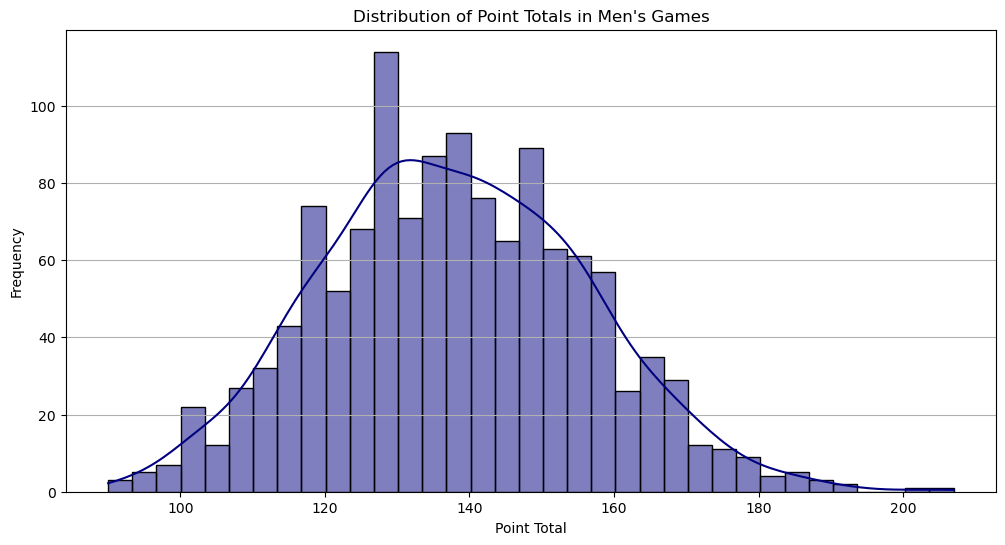

In [17]:
# plot distribution of point total
plt.figure(figsize=(12, 6))
sns.histplot(mfeatures['point_total_adj'], bins=int(np.sqrt(mfeatures.shape[0])), color='navy', kde=True)
plt.title('Distribution of Point Totals in Men\'s Games')
plt.xlabel('Point Total')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

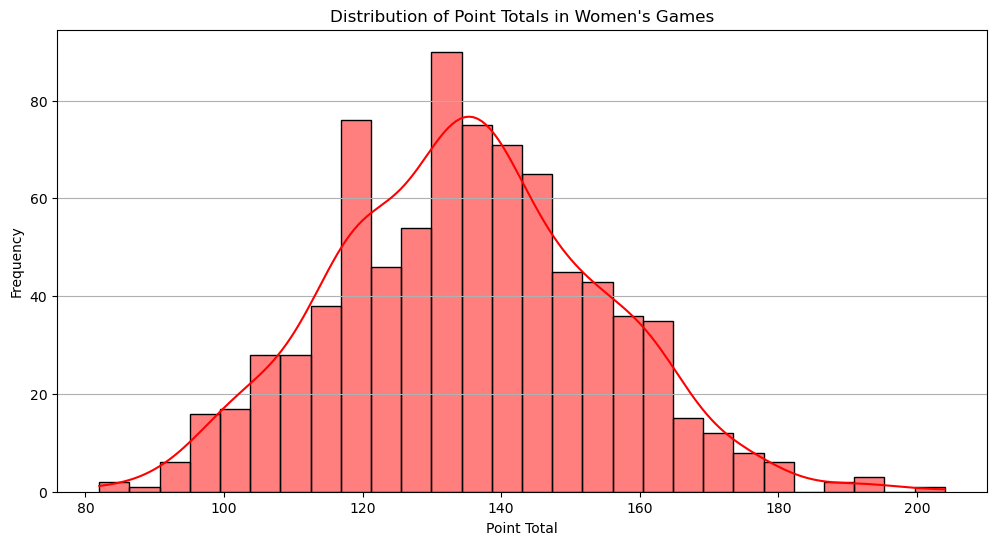

In [18]:
# plot distribution of point total
plt.figure(figsize=(12, 6))
sns.histplot(wfeatures['point_total_adj'], bins=int(np.sqrt(wfeatures.shape[0])), color='red', kde=True)
plt.title('Distribution of Point Totals in Women\'s Games')
plt.xlabel('Point Total')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [43]:
mfeatures.point_total_adj.describe(), wfeatures.point_total_adj.describe()

(count    1259.000000
 mean      137.892657
 std        18.327032
 min        90.000000
 25%       125.000000
 50%       137.000000
 75%       151.000000
 max       207.000000
 Name: point_total_adj, dtype: float64,
 count    819.000000
 mean     135.026541
 std       19.191842
 min       82.000000
 25%      121.000000
 50%      135.000000
 75%      148.000000
 max      204.000000
 Name: point_total_adj, dtype: float64)

For both genders, distiburions are pretty normal for the target variable. On average, about 3 more points are scored in men's games.

## Regression
Here, we train some models to predict __point total__.

In [45]:
# non-feature cols
labels = ['A_win', 'A_score_diff_adj', 'point_total_adj']

# look at num feats for the 2 datasets
print(f'Features of both team A and B: {mfeatures.shape[1] - len(labels)}')
print(f'Features of the DIFFERENCE between team A and B: {mfeatures_diff.shape[1] - len(labels)}')

Features of both team A and B: 217
Features of the DIFFERENCE between team A and B: 117


In [46]:
# create feature order list so our models are trained on the same feature order
sorted_cols = sorted(mfeatures.columns)
diff_cols = sorted(mfeatures_diff.columns)

# sort all dataframes
mfeatures = mfeatures[sorted_cols]
wfeatures = wfeatures[sorted_cols]
mfeatures_diff = mfeatures_diff[diff_cols]
wfeatures_diff = wfeatures_diff[diff_cols]

In [47]:
def predict_point_total(estimator, data, models_df, tournament, scaler=None, folds=5):
    """
    Validate a regression model on input data and save results to models_df.

    Parameters
    ----------
    estimator : sklearn estimator
        Estimator to use for modeling.
    data : pd.DataFrame
        Data to model.
    scaler : sklearn scaler
        Scaler to use for data.
    models_df : pd.DataFrame
        DataFrame to save results to.
    tournament : str
        Gender - 'M' or 'F'.
    folds : int
        Number of cross-validation folds to use.

    Returns
    -------
    None
    """
    
    # create copy to avoid modification
    data = data.copy()

    # define cross-validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)

    # define X and y
    X = data.drop(columns=['A_win', 'A_score_diff_adj', 'point_total_adj'])
    y = data['point_total_adj']

    # initialize lists to store metrics
    rmse_scores_train = []
    rmse_scores_test = []
    r2_scores_train = []
    r2_scores_test = []

    for train_index, test_index in kf.split(X):
        # split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if scaler:
            # scale data
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # fit model
        estimator.fit(X_train, y_train)

        # predict
        train_preds = estimator.predict(X_train)
        test_preds = estimator.predict(X_test)

        # evaluate
        rmse_scores_train.append(root_mean_squared_error(y_train, train_preds))
        rmse_scores_test.append(root_mean_squared_error(y_test, test_preds))
        r2_scores_train.append(r2_score(y_train, train_preds))
        r2_scores_test.append(r2_score(y_test, test_preds))

    # average the metrics across folds
    train_rmse = np.mean(rmse_scores_train)
    test_rmse = np.mean(rmse_scores_test)
    train_r2 = np.mean(r2_scores_train)
    test_r2 = np.mean(r2_scores_test)
    
    # Save results to models_df
    models_df.loc[len(models_df.index)] = [tournament, 'point_total_adj', estimator, scaler, X.shape[1], X.columns.to_list(), folds, train_r2, test_r2, train_rmse, test_rmse]

    # delete variables
    collect()
    
    return

### Men's

In [50]:
# create a df to hold regression models
# pt_df = pd.DataFrame(columns=['Tournament', 'Label', 'Model', 'Scaler', 'Num_Features', 'Features', 'Num_CV_Folds', 'Train_R2', 'Val_R2', 'Train_RMSE', 'Val_RMSE'])

# load models df
pt_df = pd.read_csv('models/point_total_models.csv')

In [48]:
# define regression models
reg_models = [LinearRegression(n_jobs=-1), RandomForestRegressor(n_jobs=-1, random_state=SEED), XGBRegressor(n_jobs=-1, random_state=SEED), SVR(), KNeighborsRegressor(n_jobs=-1)] 
mdatasets = [mfeatures, mfeatures_diff]
scalers = [None, StandardScaler(), MinMaxScaler()]

# run regression models
for model in tqdm(reg_models, desc='Model', file=sys.stdout):
    for dataset in mdatasets:
        for scaler in scalers:
            # run model
            predict_point_total(estimator=model, data=dataset, models_df=pt_df, tournament='M', scaler=scaler)

Model: 100%|██████████| 5/5 [00:57<00:00, 11.55s/it]


In [49]:
# inspect
pt_df[(pt_df['Tournament'] == 'M') & ((pt_df['Num_Features'] == 117) | (pt_df['Num_Features'] == 217))].sort_values(by='Val_RMSE', ascending=True).head()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE
7,M,point_total_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",StandardScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.888022,0.197783,6.128866,16.346590
8,M,point_total_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",MinMaxScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.888082,0.197452,6.127237,16.350171
6,M,point_total_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",None,217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.888038,0.197251,6.128447,16.352207
19,M,point_total_adj,SVR(),StandardScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.154495,0.080477,16.841529,17.506696
20,M,point_total_adj,SVR(),MinMaxScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.127755,0.080295,17.105904,17.508898


### Women's

In [50]:
# women's data
wdatasets = [wfeatures, wfeatures_diff]

# run regression models
for model in tqdm(reg_models, desc='Model', file=sys.stdout):
    for dataset in wdatasets:
        for scaler in scalers:
            # run model
            predict_point_total(estimator=model, data=dataset, models_df=pt_df, tournament='W', scaler=scaler)

Model: 100%|██████████| 5/5 [00:36<00:00,  7.39s/it]


In [52]:
# inspect
pt_df[(pt_df['Tournament'] == 'W') & ((pt_df['Num_Features'] == 117) | (pt_df['Num_Features'] == 217))].sort_values(by='Val_RMSE', ascending=True).head()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE
36,W,point_total_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",None,217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.889429,0.180749,6.374306,17.224268
37,W,point_total_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",StandardScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.889372,0.180350,6.375929,17.228394
38,W,point_total_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",MinMaxScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.889380,0.180274,6.375717,17.229490
44,W,point_total_adj,"XGBRegressor(base_score=None, booster=None, ca...",MinMaxScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.999999,0.087234,0.016169,18.182759
43,W,point_total_adj,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.999999,0.087234,0.016169,18.182759


In [53]:
# save models df
pt_df.to_csv('models/point_total_models.csv', index=False)

### Takeaways:
- As expected, the individual team data (non-differenced) performed better when predicting a game's point total.
- Predicting point total resulted in a much higher R2 for the validation data, and a much lower RMSE (in proportion to the label) than predicting score differential.
- Now, we can iterate through models to find the best predictor of point total.

## Model tuning (Point total)
In this section, we look at some of the most promising models from the "Regression/Classification" section and attempt to milk as much accuracy as possible.

In [48]:
# this function will be used later in the "Classification" section
def predict_win(estimator, data, models_df, tournament, scaler=None, folds=5):
    """
    Validate a classification model on input data and save results to models_df.

    Parameters
    ----------
    estimator : sklearn estimator
        Estimator to use for modeling.
    data : pd.DataFrame
        Data to model.
    scaler : sklearn scaler
        Scaler to use for data.
    models_df : pd.DataFrame
        DataFrame to save results to.
    tournament : str
        Gender - 'M' or 'F'.
    folds : int
        Number of cross-validation folds to use.

    Returns
    -------
    None
    """
    
    # create copy to avoid modification
    data = data.copy()

    # define cross-validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)

    # define X and y
    X = data.drop(columns=['A_win', 'A_score_diff_adj', 'point_total_adj'])
    y = data['A_win']

    # initialize lists to store metrics
    log_loss_train = []
    log_loss_test = []
    acc_scores_train = []
    acc_scores_test = []

    for train_index, test_index in kf.split(X):
        # split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if scaler:
            # scale data
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # fit model
        estimator.fit(X_train, y_train)

        # predict
        train_preds = estimator.predict(X_train)
        test_preds = estimator.predict(X_test)


        # evaluate
        log_loss_train.append(log_loss(y_train, train_preds))
        log_loss_test.append(log_loss(y_test, test_preds))
        acc_scores_train.append(accuracy_score(np.sign(y_train), np.sign(train_preds)))
        acc_scores_test.append(accuracy_score(np.sign(y_test), np.sign(test_preds)))

    # average the metrics across folds
    train_log_loss = np.mean(log_loss_train)
    test_log_loss = np.mean(log_loss_test)
    train_acc = np.mean(acc_scores_train)
    test_acc = np.mean(acc_scores_test)
    
    # save results to models_df
    models_df.loc[len(models_df.index)] = [tournament, 'A_win', estimator, scaler, X.shape[1], X.columns.to_list(), folds, train_log_loss, test_log_loss, train_acc, test_acc]

    # delete variables
    collect()
    
    return

### Objective functions for Bayesian Optimization

In [63]:
# random forest
def rf_objective_function_wrapper(data, tournament, regression, scaler=None):
    """
    Wrapper function to include non-hyperparameter arguments.
    """

    def rf_objective_function(max_samples, max_features, max_depth, min_samples_split, min_samples_leaf):
        """
        Objective function for Bayesian optimization of random forest hyperparameters.
        """

        # convert to integer
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)

        # create model
        if regression == True:
            model = RandomForestRegressor(n_estimators=1000, max_samples=max_samples, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, 
                                        min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=SEED)
            
            # run model
            predict_point_total(estimator=model, data=data, models_df=pt_df, tournament=tournament, scaler=scaler)

            # return negative validation RMSE
            return -pt_df[pt_df['Tournament'] == tournament]['Val_RMSE'].values[-1]

        elif regression == False:
            model = RandomForestClassifier(n_estimators=1000, max_samples=max_samples, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, 
                                        min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=SEED)

            # run model
            predict_win(estimator=model, data=data, models_df=class_df, tournament=tournament, scaler=scaler)

            # return negative validation LogLoss
            return -pt_df[pt_df['Tournament'] == tournament]['Val_LogLoss'].values[-1]
        
    return rf_objective_function

In [68]:
# xgboost
def xgb_objective_function_wrapper(data, tournament, regression, scaler=None):
    """
    Wrapper function to include non-hyperparameter arguments.
    """

    def xgb_objective_function(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
        """
        Objective function for Bayesian optimization of random forest hyperparameters.
        """

        # convert to integer
        max_depth = int(max_depth)

        # create model
        if regression == True:
            model = XGBRegressor(n_estimators=10000, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma, min_child_weight=min_child_weight, subsample=subsample, 
                                    colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1, random_state=SEED)
            
            # run model
            predict_point_total(estimator=model, data=data, models_df=pt_df, tournament=tournament, scaler=scaler)

            # return negative validation RMSE
            return -pt_df[pt_df['Tournament'] == tournament]['Val_RMSE'].values[-1]

        elif regression == False:
            model = XGBClassifier(n_estimators=10000, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma, min_child_weight=min_child_weight, subsample=subsample, 
                                  colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1, random_state=SEED)

            # run model
            predict_win(estimator=model, data=data, models_df=class_df, tournament=tournament, scaler=scaler)

            # return negative validation LogLoss
            return -pt_df[pt_df['Tournament'] == tournament]['Val_LogLoss'].values[-1]
        
    return xgb_objective_function

### Men's

In [66]:
# define bounds
rf_bounds = {
    'max_samples': (0.5, 1),
    'max_features': (0.5, 1),
    'max_depth': (1, 100),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50)
}

# create optimizer
rf_optimizer = BayesianOptimization(f=rf_objective_function_wrapper(data=mfeatures, tournament='M', regression=True, scaler=StandardScaler()), pbounds=rf_bounds, random_state=SEED)

# run optimization
rf_optimizer.maximize(init_points=10, n_iter=200)

|   iter    |  target   | max_depth | max_fe... | max_sa... | min_sa... | min_sa... |
-------------------------------------------------------------------------------------
| 1         | -16.23    | 55.33     | 0.8576    | 0.8014    | 27.7      | 22.34     |
| 2         | -16.32    | 64.94     | 0.7188    | 0.9459    | 48.22     | 20.41     |
| 3         | -16.32    | 79.38     | 0.7644    | 0.784     | 46.35     | 5.41      |
| 4         | -16.29    | 9.626     | 0.5101    | 0.9163    | 39.13     | 43.76     |
| 5         | -16.29    | 97.88     | 0.8996    | 0.7307    | 39.25     | 7.677     |
| 6         | -16.22    | 64.35     | 0.5717    | 0.9723    | 26.57     | 21.9      |
| 7         | -16.25    | 27.19     | 0.8871    | 0.7281    | 28.85     | 2.902     |
| 8         | -16.31    | 62.15     | 0.806     | 0.8085    | 47.24     | 34.73     |
| 9         | -16.19    | 36.59     | 0.7185    | 0.8488    | 3.951     | 34.0      |
| 10        | -16.21    | 67.39     | 0.6052    | 0.56

In [69]:
# define bounds
xgb_bounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.0001, 0.01),
    'gamma': (0, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10)
}

# create optimizer
xgb_optimizer = BayesianOptimization(f=xgb_objective_function_wrapper(data=mfeatures, tournament='M', regression=True, scaler=StandardScaler()), pbounds=xgb_bounds, random_state=SEED)

# run optimization
xgb_optimizer.maximize(init_points=10, n_iter=200)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -16.47    | 0.7744    | 7.152     | 0.006067  | 5.904     | 4.813     | 6.459     | 4.376     | 0.9459    |
| 2         | -16.59    | 0.9818    | 3.834     | 0.007938  | 5.76      | 6.112     | 9.256     | 0.7104    | 0.5436    |
| 3         | -16.45    | 0.5101    | 8.326     | 0.007804  | 8.83      | 9.808     | 7.992     | 4.615     | 0.8903    |
| 4         | -16.33    | 0.5591    | 6.399     | 0.001519  | 9.502     | 5.697     | 4.147     | 2.646     | 0.8871    |
| 5         | -16.24    | 0.7281    | 5.684     | 0.000286  | 6.559     | 6.509     | 6.169     | 9.437     | 0.8409    |
| 6         | -16.85    | 0.6798    | 4.37      | 0.007007  | 1.542     | 7.001     | 6.706     | 2.104     | 0.5645    |
| 7         | -16.88    

KeyboardInterrupt: 

#### Residuals

In [7]:
# plot predictions vs. actual values
def plot_preds(data, estimator, title, scaler=None):
    """
    Plot predictions vs. actual values.

    Parameters
    ----------
    data : pd.Series
        Label (point_total_adj).
    estimator : sklearn estimator
        Estimator to use for modeling.
    title : str
        Title of the plot.
    scaler : sklearn scaler
        Scaler to use for data.

    Returns
    -------
    None
    """

    # get X and y
    X = data.drop(columns=['point_total_adj', 'A_win'])
    y = data['point_total_adj']

    # scale data
    if scaler:
        pipeline = make_pipeline(
            scaler,
            estimator
        )
    else:
        pipeline = estimator


    # cross validate, get preds
    preds = cross_val_predict(pipeline, X, y, cv=5)

    # print min and max preds
    print(f'Min predicted point total: {preds.min()}')
    print(f'Max predicted point total: {preds.max()}')

    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # scatter plot
    ax.scatter(y, preds, alpha=0.5, color='red')

    # add line for perfect predictions
    min_val, max_val = y.min(), y.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

    # set y-axis limits to ignore extreme values for plotting purposes
    ax.set_ylim([y.min() - 10, y.max() + 10])

    # labels
    ax.set_xlabel('Actual Pt Total')
    ax.set_ylabel('Predicted Pt Total')
    ax.set_title(title)

    plt.show()

In [84]:
# rf best params
rf_optimizer.max['params']

{'max_depth': 46.01627111327532,
 'max_features': 1.0,
 'max_samples': 0.5,
 'min_samples_leaf': 5.744631861910375,
 'min_samples_split': 7.518248220894263}

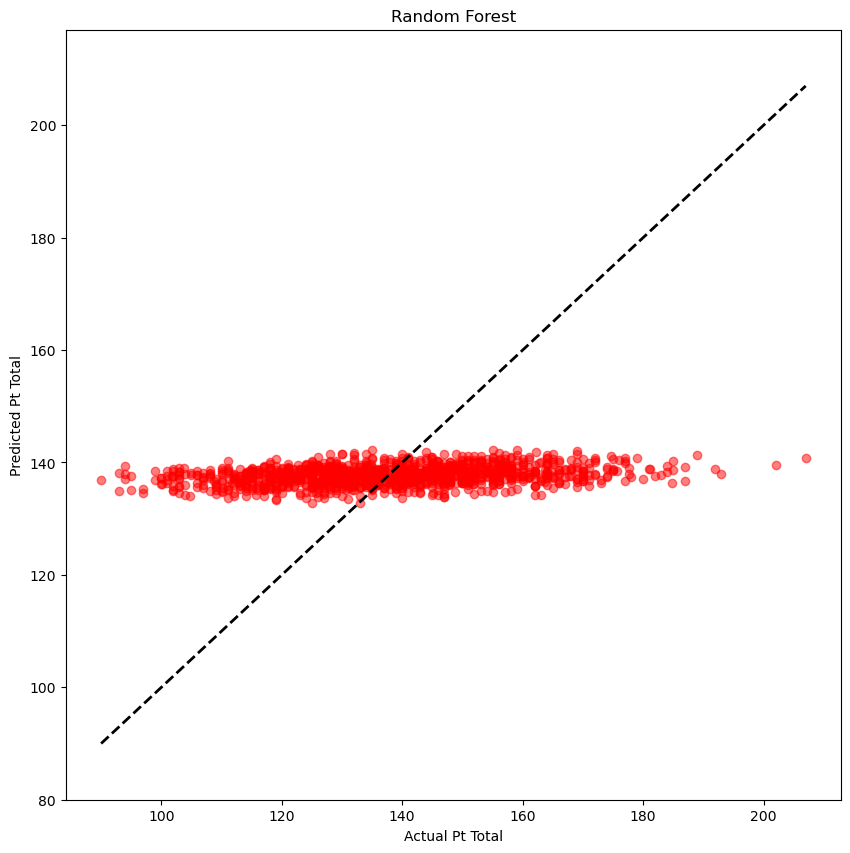

In [113]:
# create model
rf_model_mens_pt = RandomForestRegressor(max_depth=46, max_features=1, max_samples=0.5, min_samples_leaf=5, min_samples_split=7, n_estimators=1000, n_jobs=-1, random_state=SEED)

# plot preds
plot_preds(mfeatures, rf_model_mens_pt, scaler=StandardScaler(), title='Random Forest')

In [86]:
# xgb best params
xgb_optimizer.max['params']

{'colsample_bytree': 0.7084677658038337,
 'gamma': 5.164764341864907,
 'learning_rate': 0.001148265514364213,
 'max_depth': 1.135781212827155,
 'min_child_weight': 9.906314528586613,
 'reg_alpha': 5.549677583456147,
 'reg_lambda': 7.83423869410109,
 'subsample': 0.8935407455603928}

Min predicted point total: 116.9578628540039
Max predicted point total: 160.01976013183594


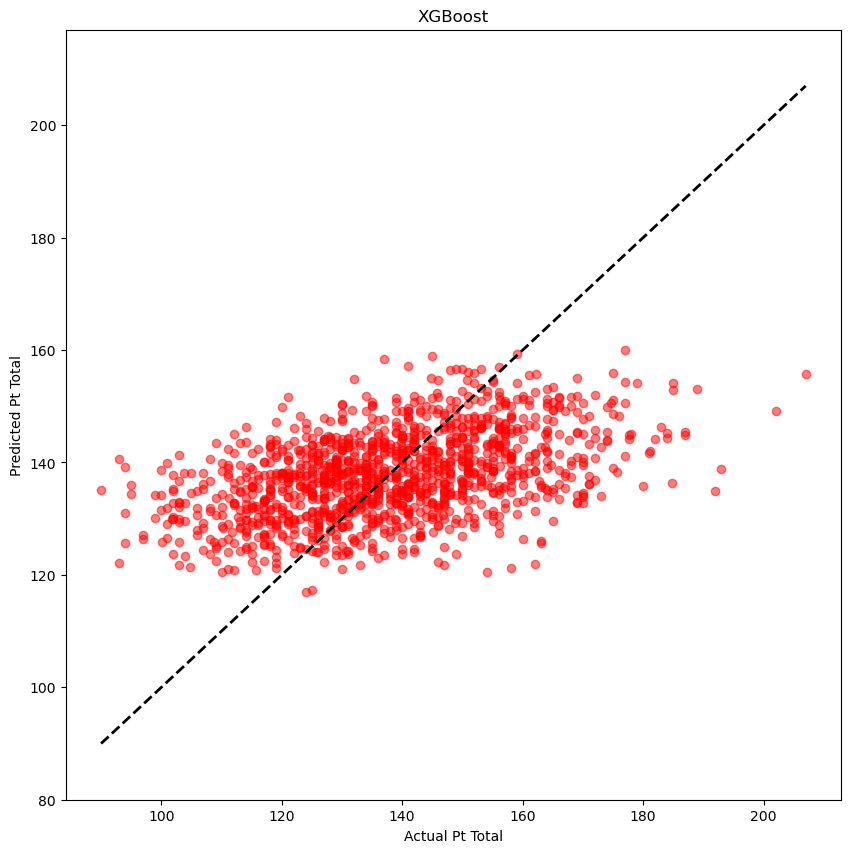

In [8]:
# create model
xgb_model_mens_pt = XGBRegressor(colsample_bytree=0.708, gamma=5.165, learning_rate=0.00115, max_depth=1, min_child_weight=9.906, reg_alpha=5.55, reg_lambda=7.834, subsample=0.894, 
                         n_estimators=10000, n_jobs=-1, random_state=SEED)

# plot preds
plot_preds(mfeatures, xgb_model_mens_pt, scaler=StandardScaler(), title='XGBoost')

Min predicted point total: -16429047272706.084
Max predicted point total: 68569102202810.6


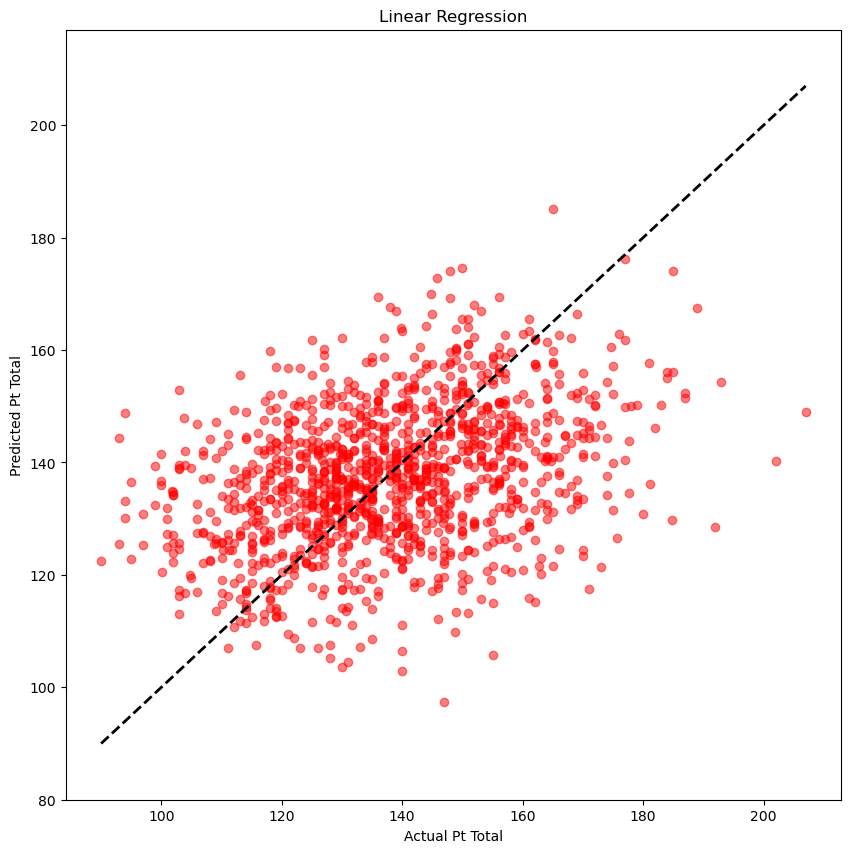

In [9]:
# linear regression
plot_preds(mfeatures, LinearRegression(n_jobs=-1), scaler=StandardScaler(), title='Linear Regression')

##### Stacking Regressor

In [51]:
# create stacking regressor
stacking_model = StackingRegressor(estimators=[('xgb', xgb_model_mens_pt)], final_estimator=LinearRegression(n_jobs=-1))

# cross validate
predict_point_total(stacking_model, mfeatures, pt_df, 'M', StandardScaler())

# look at results
pt_df[pt_df['Tournament'] == 'M'].tail()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE
26,M,point_total_adj,KNeighborsRegressor(n_jobs=-1),MinMaxScaler(),217,"['A_PlayIn', 'A_SeedNum', 'A_avg_Ast_against',...",5,0.302175,-0.085554,15.299545,19.018694
27,M,point_total_adj,KNeighborsRegressor(n_jobs=-1),NaN,117,"['A_PlayIn', 'A_away_missing', 'A_close_game_m...",5,0.234582,-0.145248,16.023177,19.525821
28,M,point_total_adj,KNeighborsRegressor(n_jobs=-1),StandardScaler(),117,"['A_PlayIn', 'A_away_missing', 'A_close_game_m...",5,0.249092,-0.142947,15.871242,19.517231
29,M,point_total_adj,KNeighborsRegressor(n_jobs=-1),MinMaxScaler(),117,"['A_PlayIn', 'A_away_missing', 'A_close_game_m...",5,0.218213,-0.177634,16.194519,19.798199
60,M,point_total_adj,"StackingRegressor(estimators=[('xgb',\n ...",StandardScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.349183,0.215693,14.775969,16.166360


In [52]:
pt_df.sort_values(by='Val_RMSE', ascending=True).head()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE
60,M,point_total_adj,"StackingRegressor(estimators=[('xgb',\n ...",StandardScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,0.349183,0.215693,14.775969,16.166360
7,M,point_total_adj,"RandomForestRegressor(n_jobs=-1, random_state=0)",StandardScaler(),217,"['A_PlayIn', 'A_SeedNum', 'A_avg_Ast_against',...",5,0.888022,0.197783,6.128866,16.346590
8,M,point_total_adj,"RandomForestRegressor(n_jobs=-1, random_state=0)",MinMaxScaler(),217,"['A_PlayIn', 'A_SeedNum', 'A_avg_Ast_against',...",5,0.888082,0.197452,6.127237,16.350171
6,M,point_total_adj,"RandomForestRegressor(n_jobs=-1, random_state=0)",NaN,217,"['A_PlayIn', 'A_SeedNum', 'A_avg_Ast_against',...",5,0.888038,0.197251,6.128447,16.352207
36,W,point_total_adj,"RandomForestRegressor(n_jobs=-1, random_state=0)",NaN,217,"['A_PlayIn', 'A_SeedNum', 'A_avg_Ast_against',...",5,0.889429,0.180749,6.374306,17.224268


Best Men's point total model resulted in a RMSE of 16.15.

In [53]:
# save
pt_df.to_csv('models/point_total_models.csv', index=False)

# Classification

In [54]:
# create a df to hold regression models
# class_df = pd.DataFrame(columns=['Tournament', 'Label', 'Model', 'Scaler', 'Num_Features', 'Features', 'Num_CV_Folds', 'Train_LogLoss', 'Val_LogLoss', 'Train_Acc', 'Val_Acc'])

# load reg df
class_df = pd.read_csv('models/classification_models_detailed.csv')

### Men's

In [103]:
# define classification models
class_models = [LogisticRegression(n_jobs=-1, random_state=SEED), RandomForestClassifier(n_jobs=-1, random_state=SEED), XGBClassifier(n_jobs=-1, random_state=SEED), SVC(), 
                KNeighborsClassifier(n_jobs=-1)]

# run models
for model in tqdm(class_models, desc='Model', file=sys.stdout):
    for dataset in mdatasets:
        for scaler in scalers:
            # run model
            predict_win(estimator=model, data=dataset, models_df=class_df, tournament='M', scaler=scaler)

Model: 100%|██████████| 5/5 [00:55<00:00, 11.18s/it]


In [111]:
# inspect
class_df[(class_df['Tournament'] == 'M') & ((class_df['Num_Features'] == 117) | (class_df['Num_Features'] == 217)) & (class_df.index > 1284)].sort_values(by='Val_Acc', ascending=False).head(10)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1290,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,8.781859e+00,11.768949,0.756355,0.673481
1308,M,A_win,SVC(),MinMaxScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,7.035489e+00,12.084414,0.804806,0.664728
1288,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,8.882030e+00,12.140942,0.753576,0.663160
1295,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",StandardScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,12.341868,1.000000,0.657586
1289,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",StandardScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,8.674522e+00,12.369563,0.759333,0.656817
1294,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",None,117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,12.427687,1.000000,0.655205
1296,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",MinMaxScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,12.484899,1.000000,0.653617
1306,M,A_win,SVC(),None,117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,6.949600e+00,12.541997,0.807189,0.652033
1285,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,8.860625e+00,12.712950,0.754170,0.647290
1305,M,A_win,SVC(),MinMaxScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,6.992545e+00,12.886410,0.805998,0.642478


### Women's

In [108]:
# run models
for model in tqdm(class_models, desc='Model', file=sys.stdout):
    for dataset in wdatasets:
        for scaler in scalers:
            # run model
            predict_win(estimator=model, data=dataset, models_df=class_df, tournament='W', scaler=scaler)

Model: 100%|██████████| 5/5 [00:46<00:00,  9.31s/it]


In [110]:
# inspect
class_df[(class_df['Tournament'] == 'W') & ((class_df['Num_Features'] == 117) | (class_df['Num_Features'] == 217)) & (class_df.index > 1284)].sort_values(by='Val_Acc', ascending=False).head(10)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1317,W,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,4.500021e+00,8.011259,0.875151,0.777735
1318,W,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,5.325096e+00,8.053866,0.852260,0.776552
1335,W,A_win,SVC(),MinMaxScaler(),217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,4.390098e+00,8.231037,0.878201,0.771637
1320,W,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,5.600305e+00,8.406321,0.844624,0.766774
1333,W,A_win,SVC(),None,217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,7.800673e+00,8.406590,0.783577,0.766766
1315,W,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,217,"[A_PlayIn, A_SeedNum, A_avg_Ast_against, A_avg...",5,4.951036e+00,8.582413,0.862638,0.761888
1338,W,A_win,SVC(),MinMaxScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,4.962159e+00,8.582952,0.862329,0.761873
1325,W,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",StandardScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,8.625020,1.000000,0.760706
1324,W,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",None,117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,8.668976,1.000000,0.759487
1326,W,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",MinMaxScaler(),117,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,8.712932,1.000000,0.758267


In [ ]:
# save class_df
class_df.to_csv('models/classification_models_detailed.csv', index=False)

### Using Predicted Point Total as a Feature

In [68]:
def predict_pt_total_and_win(tournament, estimator_pt, data_pt, scaler_pt, estimator_win, data_win, scaler_win):
    """
    Validate a classification model on input data and save results to models_df.

    Parameters
    ----------
    tournament : str
        Gender - 'M' or 'F'.
    estimator_pt : sklearn estimator
        Estimator to use for predicting point total.
    data_pt : pd.DataFrame
        Data used by estimator_pt.
    scaler_pt : sklearn scaler
        Scaler to use on data_pt.
    estimator_win : sklearn estimator
        Estimator to use for predicting win.
    data_win : pd.DataFrame
        Data used by estimator_win.
    scaler_win : sklearn scaler
        Scaler to use on data_win.

    Returns
    -------
    None
    """
    
    # create copy to avoid modification
    data_pt = data_pt.copy()
    data_win = data_win.copy()

    # define folds
    kf_pt = KFold(n_splits=2, shuffle=True, random_state=SEED)
    kf_win = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # define X and y
    X_pt = data_pt.drop(columns=['A_win', 'A_score_diff_adj', 'point_total_adj'])
    y_pt = data_pt['point_total_adj']

    # regression kfold loop. we train model on 50% of data and predict on the other 50%
    for train_index_pt, test_index_pt in kf_pt.split(X_pt):
        # split data
        X_train_pt, X_test_pt = X_pt.iloc[train_index_pt], X_pt.iloc[test_index_pt]
        y_train_pt, y_test_pt = y_pt.iloc[train_index_pt], y_pt.iloc[test_index_pt]

        if scaler_pt:
            # scale data
            X_train_pt = scaler_pt.fit_transform(X_train_pt)
            X_test_pt = scaler_pt.transform(X_test_pt)

        # fit model
        estimator_pt.fit(X_train_pt, y_train_pt)

        # predict
        test_preds_pt = estimator_pt.predict(X_test_pt)

        # define X and y (for win model)
        X_win = data_win.iloc[test_index_pt].drop(columns=['A_win', 'A_score_diff_adj', 'point_total_adj'])
        y_win = data_win.iloc[test_index_pt]['A_win']

        # add point total predictions to X_win
        X_win['predicted_totals'] = test_preds_pt

        # initialize lists to store metrics
        log_loss_train = []
        log_loss_test = []
        acc_scores_train = []
        acc_scores_test = []

        # classification kfold loop
        for train_index_win, test_index_win in kf_win.split(X_win):
            X_train_win, X_test_win = X_win.iloc[train_index_win], X_win.iloc[test_index_win]
            y_train_win, y_test_win = y_win.iloc[train_index_win], y_win.iloc[test_index_win]

            if scaler_win:
                # scale data
                X_train_win = scaler_win.fit_transform(X_train_win)
                X_test_win = scaler_win.transform(X_test_win)

            # fit model
            estimator_win.fit(X_train_win, y_train_win)

            # predict
            train_preds_win = estimator_win.predict(X_train_win)
            test_preds_win = estimator_win.predict(X_test_win)

            # evaluate
            log_loss_train.append(log_loss(y_train_win, train_preds_win))
            log_loss_test.append(log_loss(y_test_win, test_preds_win))
            acc_scores_train.append(accuracy_score(y_train_win, train_preds_win))
            acc_scores_test.append(accuracy_score(y_test_win, test_preds_win))

        # average the metrics across folds
        train_log_loss = np.mean(log_loss_train)
        test_log_loss = np.mean(log_loss_test)
        train_acc = np.mean(acc_scores_train)
        test_acc = np.mean(acc_scores_test)
    
        # save results to class_df
        class_df.loc[len(class_df.index)] = [tournament, 'A_win', estimator_win, scaler_win, X_win.shape[1], X_win.columns.to_list(), 5, train_log_loss, test_log_loss, train_acc, test_acc]

    # delete variables
    collect()
    
    return

In [69]:
class_models = [LogisticRegression(n_jobs=-1, random_state=SEED), RandomForestClassifier(n_jobs=-1, random_state=SEED), XGBClassifier(n_jobs=-1, random_state=SEED), SVC(), 
                KNeighborsClassifier(n_jobs=-1)]
scalers = [None, StandardScaler(), MinMaxScaler()]

In [70]:
# run models
for scaler in scalers:
    # run model
    predict_pt_total_and_win(tournament='M', estimator_pt=xgb_model_mens_pt, data_pt=mfeatures, scaler_pt=StandardScaler(), estimator_win=LogisticRegression(n_jobs=-1, random_state=SEED), data_win=mfeatures_diff, scaler_win=scaler)

Model: 100%|██████████| 5/5 [03:24<00:00, 40.86s/it]


In [75]:
# inspect
class_df.tail(30).sort_values(by='Val_Acc', ascending=False)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1289,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,7.451882e+00,9.668853,0.793254,0.731746
1290,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,6.432272e+00,9.683957,0.821542,0.731327
1307,M,A_win,SVC(),MinMaxScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,6.021579e+00,9.897702,0.832937,0.725397
1293,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",StandardScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,9.954914,1.000000,0.723810
1295,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",MinMaxScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,9.954914,1.000000,0.723810
1291,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",None,118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,10.012126,1.000000,0.722222
1292,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",None,118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,10.028145,1.000000,0.721778
1296,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",MinMaxScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,10.028145,1.000000,0.721778
1306,M,A_win,SVC(),StandardScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.550035e+00,10.085357,0.929251,0.720190
1294,M,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",StandardScaler(),118,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,10.085357,1.000000,0.720190


## Discretizer for Classification
We will use KBinsDiscretizer to transform our continuous statistics into discrete variables. This adds non-linearity to linear models like LogReg and SVC.

#### Men's

In [194]:
# look at default logreg performance on men's
logreg_model = LogisticRegression(n_jobs=-1, random_state=SEED)

# cross validate
run_model(estimator=logreg_model, data=mfeatures_diff, regression=False, models_df=class_df, tournament='M', scaler=None)

# look at results
class_df[class_df['Tournament'] == 'M'].tail(1)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1105,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,9.061052,12.254341,0.748609,0.660014


In [215]:
# get categorical cols
cat_cols = [col for col in cols_to_keep if col not in ['A_TeamID', 'B_TeamID']]

# 5 different bin sizes
for bin in [60, 70, 80, 90, 100]:
    mfeatures_discrete = KBinsDiscretizer(n_bins=bin, encode='ordinal', strategy='uniform', subsample=None).fit_transform(mfeatures_diff.drop(columns=cat_cols))
    mfeatures_discrete = pd.DataFrame(mfeatures_discrete, columns=mfeatures_diff.drop(columns=cat_cols).columns)
    mfeatures_discrete = pd.concat([mfeatures_discrete, mfeatures_diff[cat_cols]], axis=1)

    # run model
    run_model(estimator=logreg_model, data=mfeatures_discrete, regression=False, models_df=class_df, tournament='M', scaler=None)

# look at results
class_df[class_df['Tournament'] == 'M'].tail()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1126,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.125402,12.168978,0.746824,0.662382
1127,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.096774,11.825022,0.747618,0.671925
1128,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.268574,11.968508,0.742851,0.667944
1129,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.168375,11.968394,0.745631,0.667947
1130,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.182706,11.996772,0.745234,0.667160


In [217]:
class_df[class_df['Tournament'] == 'M'].tail(15)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1116,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.003776,12.053870,0.750198,0.665576
1117,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.139797,12.025036,0.746424,0.666376
1118,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.061059,12.626676,0.748609,0.649684
1119,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.061045,11.967482,0.748609,0.667973
1120,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.168375,12.053414,0.745631,0.665588
1121,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.039548,11.595717,0.749206,0.678287
1122,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.032411,11.825136,0.749404,0.671922
1123,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.125465,11.853856,0.746822,0.671125
1124,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.154050,12.025492,0.746029,0.666363
1125,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.082485,11.738748,0.748014,0.674319


Now, we can use the predicted total as a feature for the classification model

## Simultate N Brackets

In [19]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'

# load data, get slots for 2024, drop play-ins
slots = pd.read_csv(mroot + 'MNCAATourneySlots.csv')
slots = slots[slots['Season'] == 2024]
slots = slots[slots['Slot'].str.contains('R')].reset_index(drop=True)

# load seed data
seeds_2024 = pd.read_csv(root + '2024_tourney_seeds.csv')

# load in 2024 data
df_2024 = pd.read_csv(root + 'processed/2024_features.csv').drop(columns=['Region', 'Season'])

# drop teams not in 2024 tourney
df_2024 = df_2024[df_2024['TeamID'].isin(seeds_2024['TeamID'])]

# drop play in char
df_2024['FullSeed'] = df_2024['FullSeed'].apply(lambda x: x[:3])

# split into mens and womens
mdf_2024 = df_2024[df_2024['TeamID'] < 3000].reset_index(drop=True)
wdf_2024 = df_2024[df_2024['TeamID'] >= 3000].reset_index(drop=True)

# delete vars
del root, mroot, wroot, seeds_2024, df_2024

In [33]:
def generate_bracket(data, estimator, tournament, num_brackets, slots_df=slots):
    """
    Generate a single bracket for the 2024 NCAA tournament.

    Parameters
    ----------
    data : pd.DataFrame
        Regular season data for the 2024 teams competing in the tournament.
    estimator : sklearn estimator
        Pre-trained estimator to use for modeling.
    tournament : str
        'M' or 'W'.
    num_brackets : int
        Number of brackets to generate.
    slots : pd.DataFrame
        Slots for the 2024 tournament.

    Returns
    -------
    all_brackets : pd.DataFrame
        DataFrame with the predicted outcomes of the tournament.
    
    """

    # get a copies of data to avoid modifying the original
    features = data.copy()

    # define scaler
    scaler = MinMaxScaler()

    # create empty df for all brackets
    all_brackets = pd.DataFrame()

    # loop for each bracket
    for n in range(1, num_brackets+1):
        # create bracket-specific slots table
        slots = slots_df.copy()

        # create empty results for round
        result_df = pd.DataFrame(columns=["Slot", "Team"])

        # 6 rounds in a single bracket
        for i in range(1, 7):
            # get slots for round
            slots_round = slots[slots['Slot'].str.contains(f'R{i}')].reset_index(drop=True)

            # holds data for each matchup
            round_matchups = []

            # loop through the slots
            for idx, row in slots_round.iterrows():
                # get team A and team B
                A = features[features['FullSeed'] == row['StrongSeed']].reset_index(drop=True)
                B = features[features['FullSeed'] == row['WeakSeed']].reset_index(drop=True)

                # rename cols
                A = A.add_prefix('A_')
                B = B.add_prefix('B_')

                # create matchup dataframe
                combined = pd.concat([A, B], axis=1)

                # append combined row to the list
                round_matchups.append(combined)

            # concatenate all matchup rows into a single DataFrame
            round_df = pd.concat(round_matchups, axis=0).reset_index(drop=True)
            
            # calculate seed diff
            round_df['A_seed_diff'] = round_df['B_Seed'] - round_df['A_Seed']

            # add some cols that were in training data
            round_df['A_Loc_A'] = 0
            round_df['A_Loc_H'] = 0
            round_df[['round_2', 'round_3', 'round_4', 'round_5', 'round_6']] = 0
            if i == 1:
                pass
            else:
                round_df[f'round_{i}'] = 1

            # drop cols
            round_df = round_df.drop(columns=['A_Seed', 'B_Seed', 'A_seed_diff'])

            # add placeholder cols for sorting
            round_df['score_diff_adj'] = 0
            round_df['win'] = 0
            round_df = round_df[sorted_cols]

            # define X and reorder cols
            X = round_df.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])

            # scale data
            X = scaler.fit_transform(X)
            
            # predict the outcomes of the round
            preds = estimator.predict_proba(X)

            # if n == 1:
            #     print(f'\n\nround {i}:')
            #     print(f'preds before: {preds}')

            # generate random values, update preds
            random_values = np.random.rand(len(preds))
            preds = (random_values > preds[:, 0]).astype(int)

            # if n == 1:
            #     print(f'random values: {random_values}')
            #     print(f'preds after: {preds}')

            # replace preds with full seed of winning team
            preds = np.where(preds > 0, round_df['A_FullSeed'], round_df['B_FullSeed'])

            for slot, winner_seed in zip(slots_round['Slot'], preds):
                # save results to result_df
                result_df.loc[len(result_df.index)] = [slot, winner_seed]

            # edit slots df for next round
            if i != 6:
                next_round_slots = slots[slots['Slot'].str.contains(f'R{i+1}')]

                for idx, row in next_round_slots.iterrows():
                    # get the teams playing in that slot for the next round
                    team1 = result_df[result_df['Slot'] == row['StrongSeed']]['Team'].values[0]
                    team2 = result_df[result_df['Slot'] == row['WeakSeed']]['Team'].values[0]

                    # update the slots df
                    slots.loc[slots['Slot'] == row['Slot'], 'StrongSeed'] = team1
                    slots.loc[slots['Slot'] == row['Slot'], 'WeakSeed'] = team2

            # drop teams that have been eliminated
            # features = features[features['FullSeed'].isin(result_df['Team'])].reset_index(drop=True)

        # add bracket col
        result_df['Bracket'] = n

        # append to all_brackets
        all_brackets = pd.concat([all_brackets, result_df], axis=0)

    # add tournament col
    all_brackets['Tournament'] = tournament

    return all_brackets


### Men's

In [22]:
# define scaler
scaler = MinMaxScaler()

In [23]:
# train best men's model on entire dataset
mmodel_reg = LinearRegression(n_jobs=-1)

# sort features
mfeatures = mfeatures[sorted_cols]

# define X and y
X = mfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = mfeatures['score_diff_adj']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
mmodel_reg.fit(X_scaled, y)

# get train metrics
train_preds = mmodel_reg.predict(X_scaled)
r2 = r2_score(y, train_preds)
rmse = mean_squared_error(y, train_preds, squared=False)
acc = accuracy_score(np.sign(y), np.sign(train_preds))

print(f'Model R2: {r2:.4f}')
print(f'Model RMSE: {rmse:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, r2, rmse, acc

Model R2: 0.4284
Model RMSE: 11.1122
Model Accuracy: 0.7192


In [24]:
# classification
mmodel_class = LogisticRegression(n_jobs=-1)

# sort features
mfeatures = mfeatures[sorted_cols]

# define X and y
X = mfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = mfeatures['win']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
mmodel_class.fit(X_scaled, y)

# get train metrics
train_preds = mmodel_class.predict(X_scaled)
loss = log_loss(y, train_preds)
acc = accuracy_score(y, train_preds)

print(f'Model Log Loss: {loss:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, loss, acc

Model Log Loss: 9.5694
Model Accuracy: 0.7229


In [34]:
# generate men's bracket
# result_m_reg = generate_bracket(data=mdf_2024, estimator=mmodel_reg, tournament='M')
m_brackets = generate_bracket(data=mdf_2024, estimator=mmodel_class, tournament='M', num_brackets=1)

# delete vars
# del mmodel_reg, mmodel_class

In [36]:
m_brackets.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
Slot,R1W1,R1W2,R1W3,R1W4,R1W5,R1W6,R1W7,R1W8,R1X1,R1X2,R1X3,R1X4,R1X5,R1X6,R1X7,R1X8,R1Y1,R1Y2,R1Y3,R1Y4,R1Y5,R1Y6,R1Y7,R1Y8,R1Z1,R1Z2,R1Z3,R1Z4,R1Z5,R1Z6,R1Z7,R1Z8,R2W1,R2W2,R2W3,R2W4,R2X1,R2X2,R2X3,R2X4,R2Y1,R2Y2,R2Y3,R2Y4,R2Z1,R2Z2,R2Z3,R2Z4,R3W1,R3W2,R3X1,R3X2,R3Y1,R3Y2,R3Z1,R3Z2,R4W1,R4X1,R4Y1,R4Z1,R5WX,R5YZ,R6CH
Team,W01,W02,W03,W04,W12,W06,W10,W09,X01,X15,X14,X04,X12,X11,X10,X08,Y01,Y02,Y14,Y04,Y12,Y11,Y10,Y09,Z01,Z02,Z14,Z13,Z12,Z11,Z07,Z09,W01,W02,W06,W04,X01,X10,X11,X04,Y01,Y02,Y11,Y04,Z01,Z02,Z11,Z12,W01,W06,X01,X11,Y04,Y02,Z12,Z02,W01,X01,Y02,Z12,W01,Z12,W01
Bracket,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Tournament,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M


### Women's

In [37]:
# train best men's model on entire dataset
wmodel_reg = LinearRegression(n_jobs=-1)

# define X and y
X = wfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = wfeatures['score_diff_adj']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
wmodel_reg.fit(X_scaled, y)

# get train metrics
train_preds = wmodel_reg.predict(X_scaled)
r2 = r2_score(y, train_preds)
rmse = mean_squared_error(y, train_preds, squared=False)
acc = accuracy_score(np.sign(y), np.sign(train_preds))

print(f'Model R2: {r2:.4f}')
print(f'Model RMSE: {rmse:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, r2, rmse, acc

Model R2: 0.6467
Model RMSE: 12.3932
Model Accuracy: 0.7956


In [38]:
# classification
wmodel_class = LogisticRegression(random_state=SEED)

# define X and y
X = wfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = wfeatures['win']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
wmodel_class.fit(X_scaled, y)

# get train metrics
train_preds = wmodel_class.predict(X_scaled)
loss = log_loss(y, train_preds)
acc = accuracy_score(y, train_preds)

print(f'Model Log Loss: {loss:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, loss, acc

Model Log Loss: 6.8640
Model Accuracy: 0.8013


In [39]:
# generate women's bracket
# result_w_reg = generate_bracket(data=wdf_2024, estimator=wmodel_reg, tournament='W')
w_brackets = generate_bracket(data=wdf_2024, estimator=wmodel_class, tournament='W', num_brackets=1)

# delete vars
# del wmodel_reg, wmodel_class

In [40]:
w_brackets.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
Slot,R1W1,R1W2,R1W3,R1W4,R1W5,R1W6,R1W7,R1W8,R1X1,R1X2,R1X3,R1X4,R1X5,R1X6,R1X7,R1X8,R1Y1,R1Y2,R1Y3,R1Y4,R1Y5,R1Y6,R1Y7,R1Y8,R1Z1,R1Z2,R1Z3,R1Z4,R1Z5,R1Z6,R1Z7,R1Z8,R2W1,R2W2,R2W3,R2W4,R2X1,R2X2,R2X3,R2X4,R2Y1,R2Y2,R2Y3,R2Y4,R2Z1,R2Z2,R2Z3,R2Z4,R3W1,R3W2,R3X1,R3X2,R3Y1,R3Y2,R3Z1,R3Z2,R4W1,R4X1,R4Y1,R4Z1,R5WX,R5YZ,R6CH
Team,W01,W02,W03,W04,W05,W11,W10,W09,X01,X02,X03,X04,X12,X06,X10,X09,Y01,Y02,Y03,Y04,Y12,Y11,Y10,Y09,Z01,Z02,Z03,Z04,Z05,Z06,Z10,Z09,W01,W02,W03,W05,X01,X02,X06,X04,Y01,Y02,Y03,Y04,Z01,Z10,Z03,Z05,W01,W02,X04,X02,Y01,Y02,Z01,Z03,W01,X02,Y01,Z03,W01,Y01,Y01
Bracket,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Tournament,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W


## Submission

In [ ]:
# num brackets
n_brackets = 100000

# combine results
submission = pd.concat([result_m_class, result_w_class])
submission = submission.reset_index(drop=True)
submission.index.names = ['RowId']

# reorder
submission = submission[['Tournament', 'Bracket', 'Slot', 'Team']]

In [ ]:
# save
submission.to_csv('submission.csv')
submission.head()

In [54]:
for col in mfeatures.columns:
    print(col)

A_1_score_game_missing
A_1_score_game_ratio
A_1_score_win_ratio
A_PlayIn
A_Seed
A_avg_Ast_against
A_avg_Ast_for
A_avg_Blk_against
A_avg_Blk_for
A_avg_DR_against
A_avg_DR_for
A_avg_FGA3_against
A_avg_FGA3_for
A_avg_FGA_against
A_avg_FGA_for
A_avg_FGM3_against
A_avg_FGM3_for
A_avg_FGM_against
A_avg_FGM_for
A_avg_FTA_against
A_avg_FTA_for
A_avg_FTM_against
A_avg_FTM_for
A_avg_OR_against
A_avg_OR_for
A_avg_PF_against
A_avg_PF_for
A_avg_Score_against
A_avg_Score_for
A_avg_Stl_against
A_avg_Stl_for
A_avg_TO_against
A_avg_TO_for
A_avg_diff
A_away_missing
A_away_win_ratio
A_conf_champs
A_home_missing
A_home_win_ratio
A_neutral_missing
A_neutral_win_ratio
A_num_games
A_ot_game_missing
A_ot_ratio
A_ot_win_ratio
A_recent_avg_Ast_against
A_recent_avg_Ast_for
A_recent_avg_Blk_against
A_recent_avg_Blk_for
A_recent_avg_DR_against
A_recent_avg_DR_for
A_recent_avg_FGA3_against
A_recent_avg_FGA3_for
A_recent_avg_FGA_against
A_recent_avg_FGA_for
A_recent_avg_FGM3_against
A_recent_avg_FGM3_for
A_recent_av